# Libraries

导入库
首先，我们将导入我们将需要的所有必要库。

In [152]:
from pandas import read_csv, unique

import numpy as np

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Data Load

In [153]:
def read_data(filepath):
    df = read_csv(filepath, header=None, names=['user-id',
                                               'activity',
                                               'timestamp',
                                               'X1',
                                               'Y1',
                                               'Z1',
                                               'X2',
                                               'Y2',
                                               'Z2',
                                               'X3',
                                               'Y3',
                                               'Z3'])
    ## removing ';' from last column and converting it to float
    df['Z3'].replace(regex=True, inplace=True, to_replace=r';', value=r'')
    df['Z3'] = df['Z3'].apply(convert_to_float)
#     df.dropna(axis=0, how='any', inplace=True)
    return df

def convert_to_float(x):
    try:
        return np.float64(x)
    except:
        return np.nan

In [154]:
df = read_data('/content/2.txt')
df

,user-id,activity,timestamp,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3
0,33,Jogging,1.676523,-0.119693,-0.065272,-0.148103,0.068357,0.133498,-0.051403,0.068357,0.133498,-0.051403
1,33,Jogging,2.676523,-0.522289,-0.151326,-0.162885,0.077630,0.053679,-0.120644,0.077630,0.053679,-0.120644
2,33,Jogging,3.676523,-0.729584,-0.070483,-0.107378,0.082546,-0.024961,-0.124492,0.082546,-0.024961,-0.124492
3,33,Jogging,4.676523,-0.743253,0.035888,-0.082211,0.095829,-0.115281,-0.079334,0.095829,-0.115281,-0.079334
4,33,Jogging,5.676523,-0.748287,0.071997,-0.033006,0.091049,-0.180213,-0.015142,0.091049,-0.180213,-0.015142
...,...,...,...,...,...,...,...,...,...,...,...,...
804,34,Jogging,805.676523,0.002772,-0.186061,0.090498,-0.030833,0.156906,0.162419,-0.030833,0.156906,0.162419
805,34,Jogging,806.676523,0.105891,-0.218552,0.052473,-0.037108,0.162628,0.125909,-0.037108,0.162628,0.125909
806,34,Jogging,807.676523,0.180300,-0.254100,0.039870,-0.040454,0.145479,0.091395,-0.040454,0.145479,0.091395
807,34,Jogging,808.676523,0.197305,-0.318481,0.037977,-0.045393,0.101749,0.047751,-0.045393,0.101749,0.047751


# Data Visualization

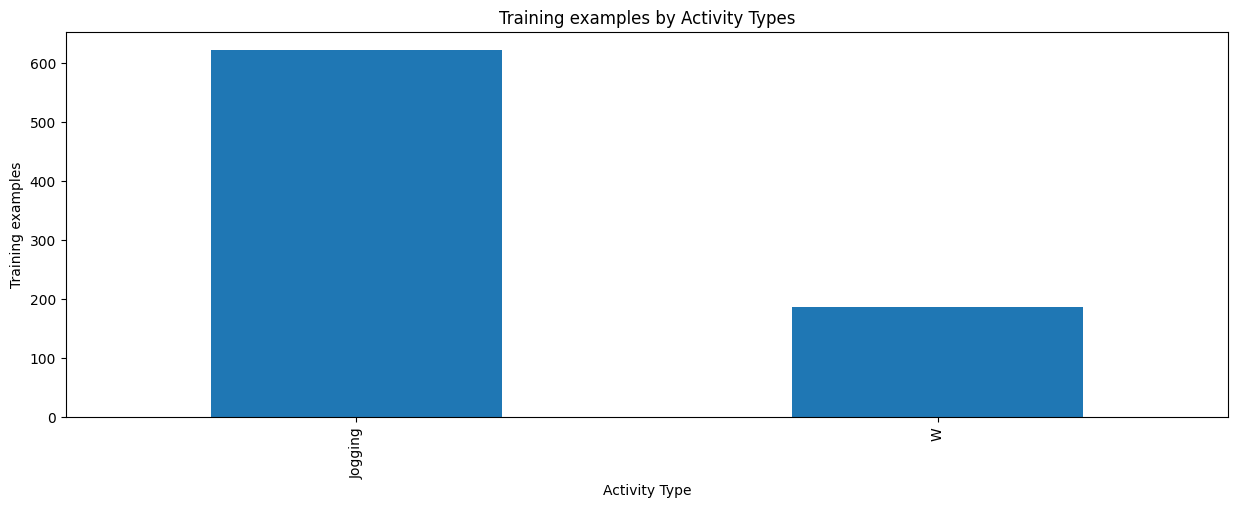

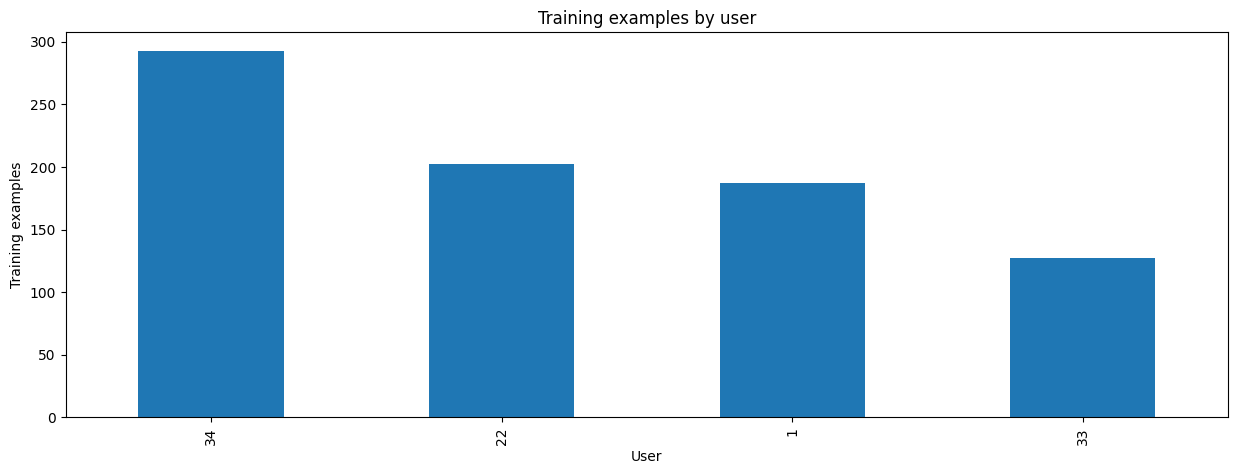

In [155]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
df['user-id'].value_counts().plot(kind='bar', 
                                 title='Training examples by user')
plt.show()

In [156]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

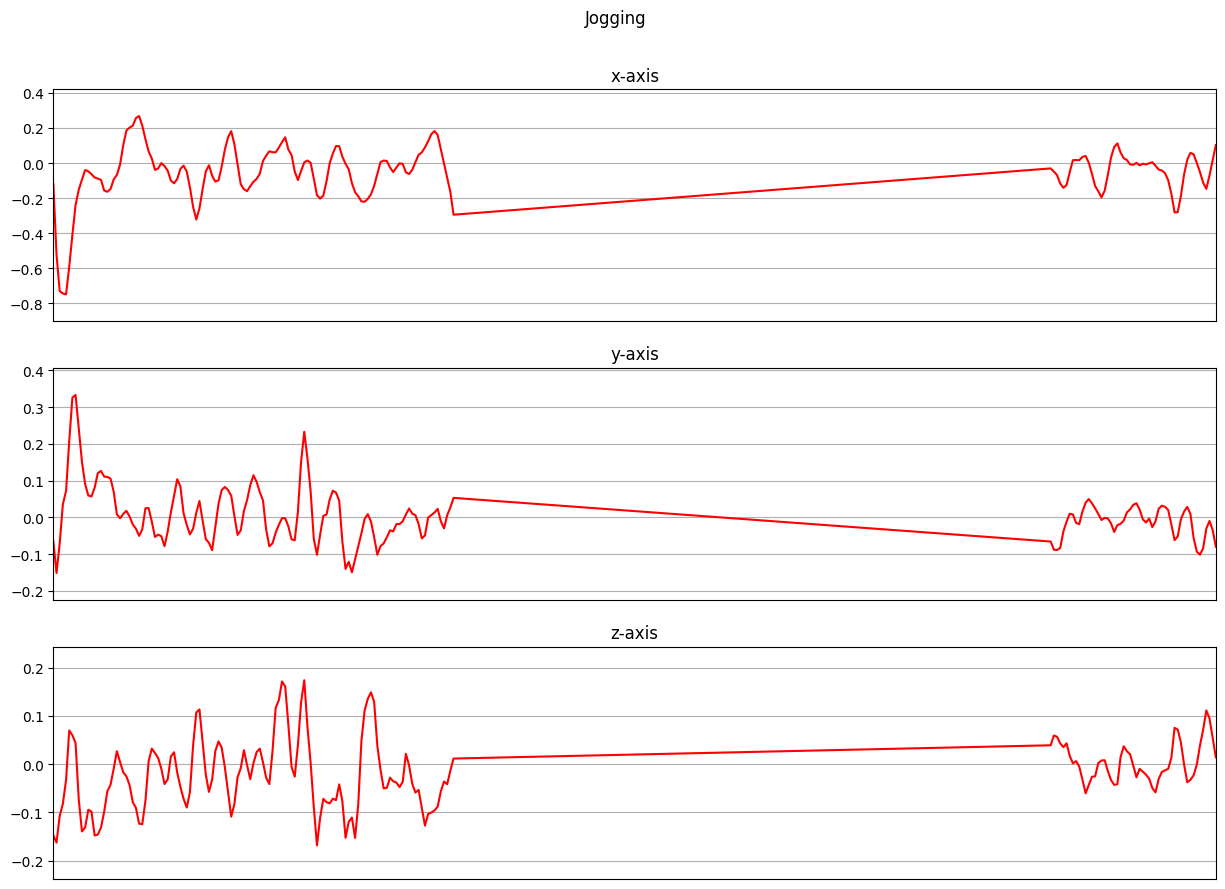

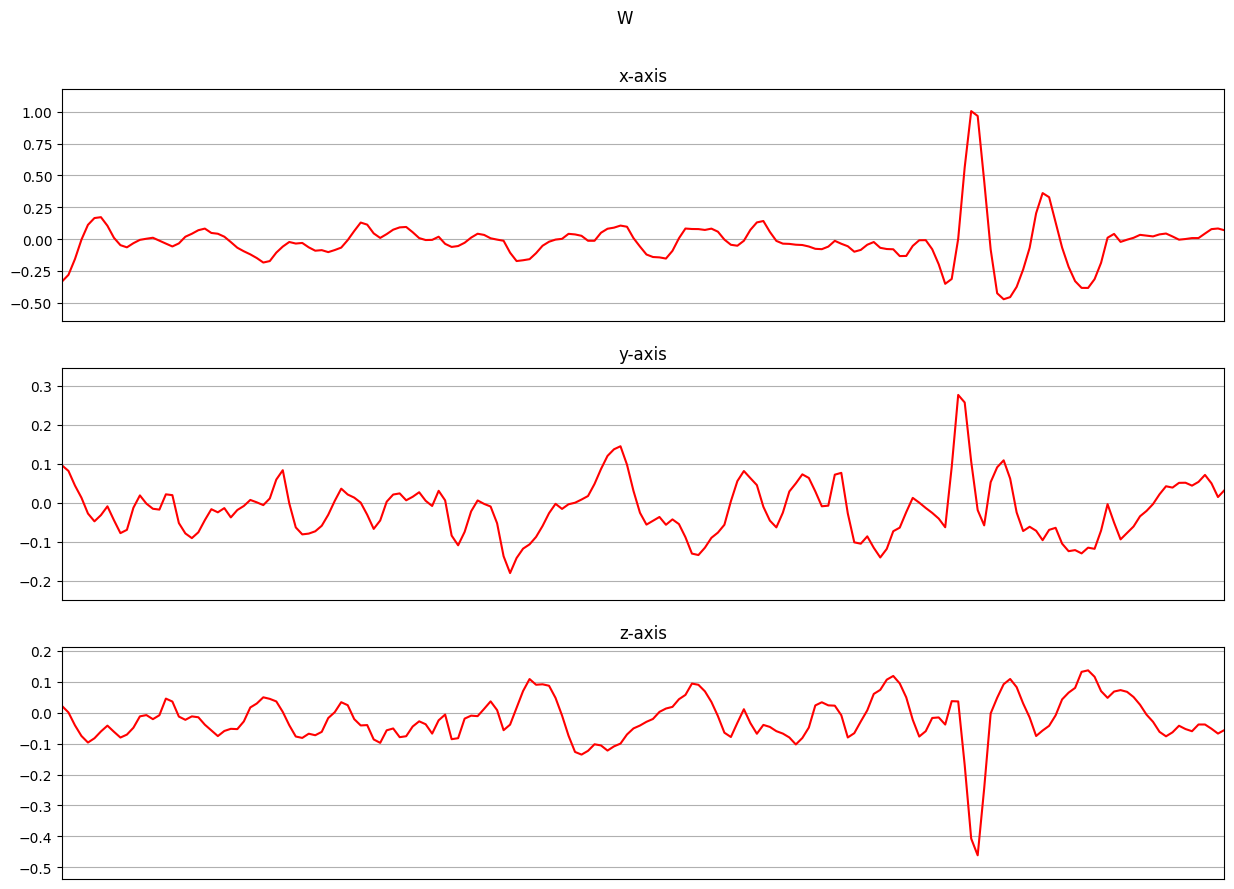

In [157]:
for activity in df['activity'].unique():
    limit = df[df['activity'] == activity][:180]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))
    axis_plot(ax0, limit['timestamp'], limit['X1'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['Y1'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['Z1'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

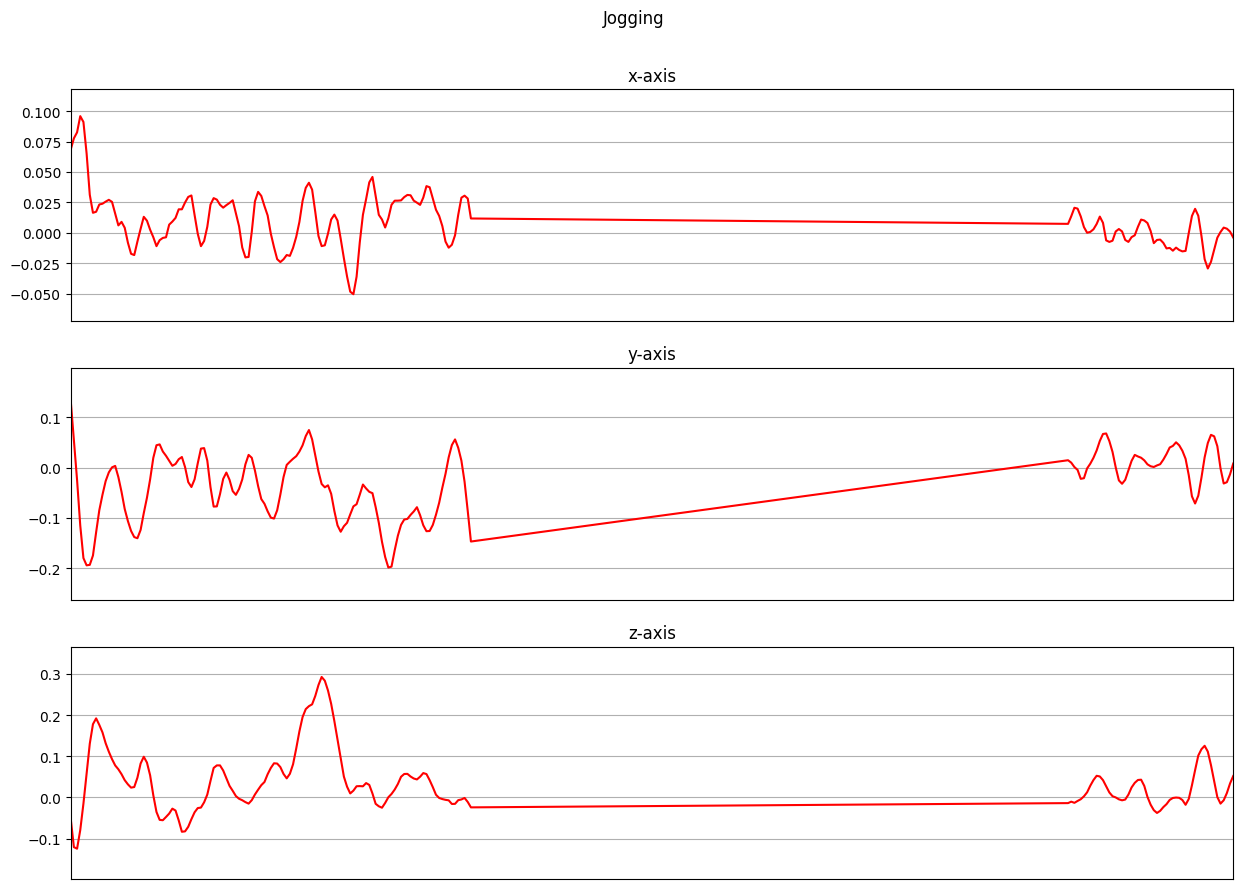

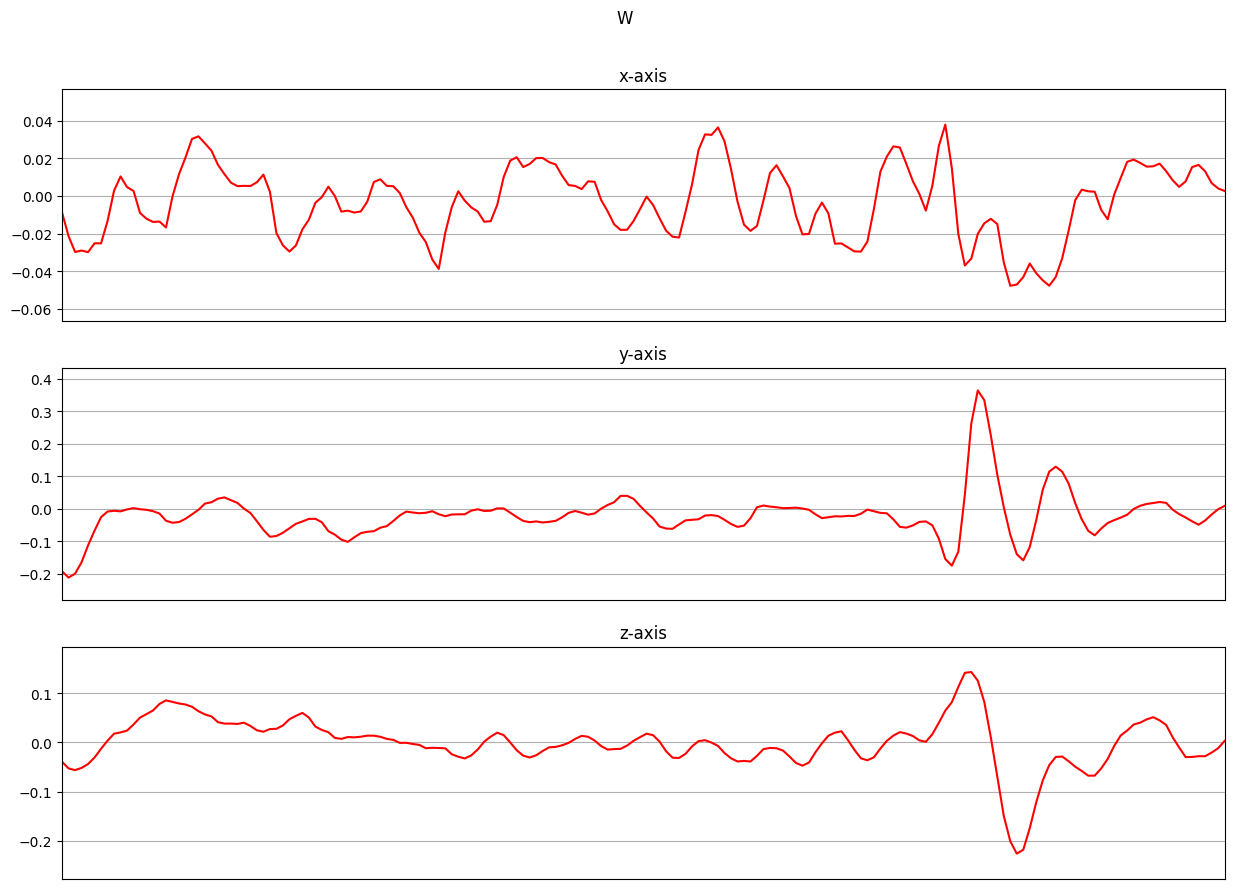

In [158]:
for activity in df['activity'].unique():
    limit = df[df['activity'] == activity][:180]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))
    axis_plot(ax0, limit['timestamp'], limit['X2'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['Y2'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['Z2'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

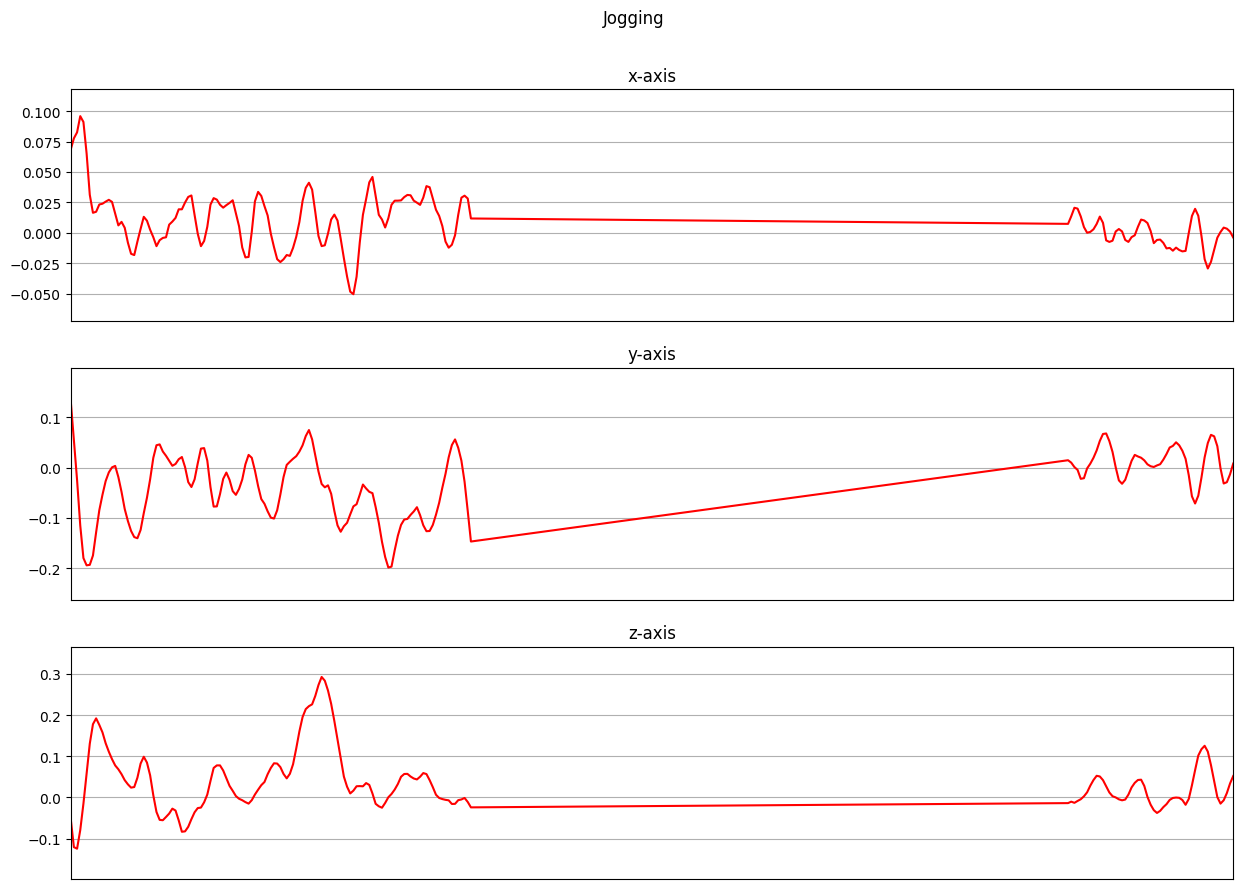

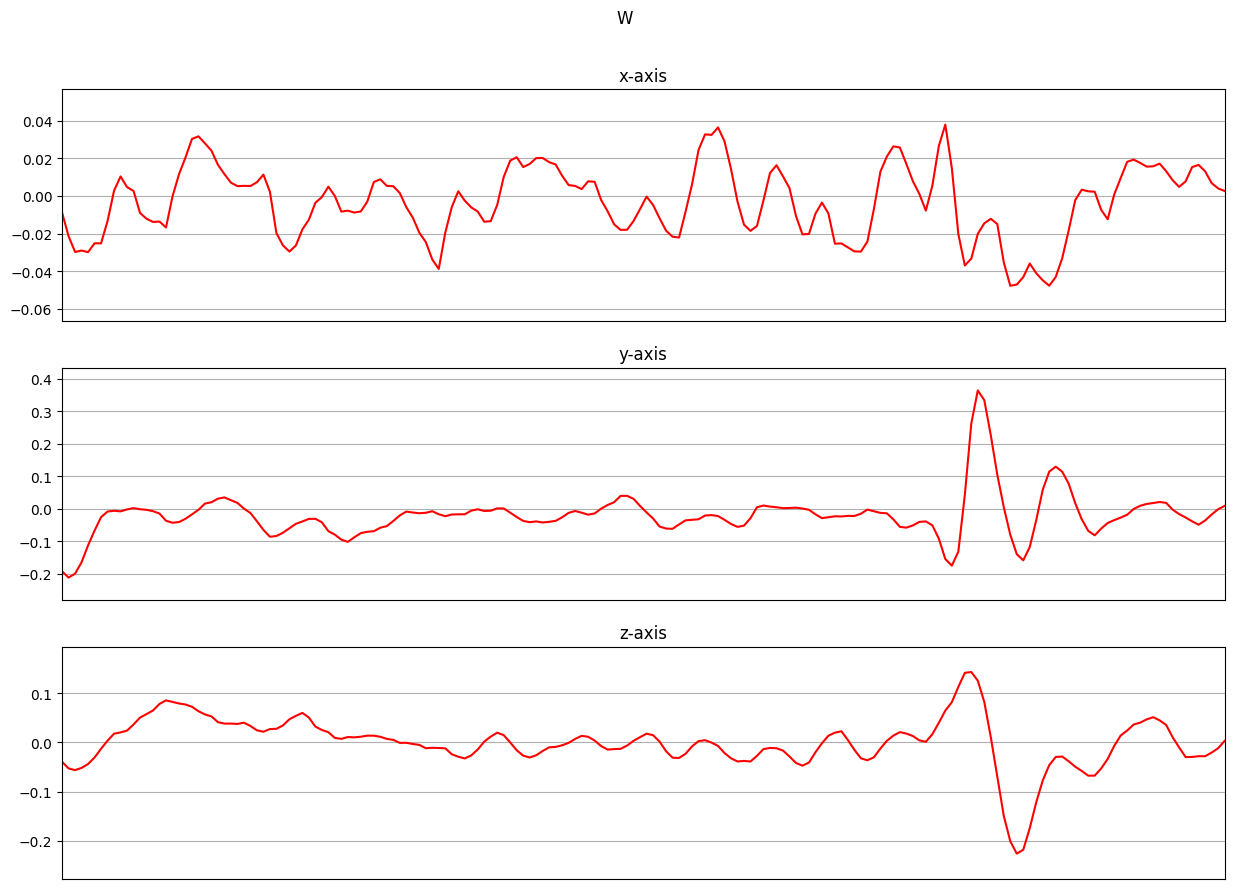

In [159]:
for activity in df['activity'].unique():
    limit = df[df['activity'] == activity][:180]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))
    axis_plot(ax0, limit['timestamp'], limit['X3'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['Y3'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['Z3'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

# Data Preprocessing

数据预处理是一项非常重要的任务，它使我们的模型能够更好地利用我们的原始数据。这里将使用的数据预处理方法有：

标签编码

线性插值

数据分割

归一化

时间序列分割

独热编码

## Label Encoding

由于模型不能接受非数字标签作为输入，我们将在另一列中添加' activity '列的编码标签，并将其命名为' activityEncode '。标签被转换成如下所示的数字标签(这个标签是我们要预测的结果标签)

In [160]:
label_encode = LabelEncoder()
df['activityEncode'] = label_encode.fit_transform(df['activity'].values.ravel())
df

,user-id,activity,timestamp,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3,activityEncode
0,33,Jogging,1.676523,-0.119693,-0.065272,-0.148103,0.068357,0.133498,-0.051403,0.068357,0.133498,-0.051403,0
1,33,Jogging,2.676523,-0.522289,-0.151326,-0.162885,0.077630,0.053679,-0.120644,0.077630,0.053679,-0.120644,0
2,33,Jogging,3.676523,-0.729584,-0.070483,-0.107378,0.082546,-0.024961,-0.124492,0.082546,-0.024961,-0.124492,0
3,33,Jogging,4.676523,-0.743253,0.035888,-0.082211,0.095829,-0.115281,-0.079334,0.095829,-0.115281,-0.079334,0
4,33,Jogging,5.676523,-0.748287,0.071997,-0.033006,0.091049,-0.180213,-0.015142,0.091049,-0.180213,-0.015142,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,34,Jogging,805.676523,0.002772,-0.186061,0.090498,-0.030833,0.156906,0.162419,-0.030833,0.156906,0.162419,0
805,34,Jogging,806.676523,0.105891,-0.218552,0.052473,-0.037108,0.162628,0.125909,-0.037108,0.162628,0.125909,0
806,34,Jogging,807.676523,0.180300,-0.254100,0.039870,-0.040454,0.145479,0.091395,-0.040454,0.145479,0.091395,0
807,34,Jogging,808.676523,0.197305,-0.318481,0.037977,-0.045393,0.101749,0.047751,-0.045393,0.101749,0.047751,0


## Linear Interpolation

利用线性插值可以避免采集过程中出现NaN的数据丢失的问题。它将通过插值法填充缺失的值。虽然在这个数据集中只有一个NaN值，但为了我们的展示，还是需要实现它。



In [161]:
df.isna().sum()

user-id           0
activity          0
timestamp         0
X1                0
Y1                0
Z1                0
X2                0
Y2                0
Z2                0
X3                0
Y3                0
Z3                0
activityEncode    0
dtype: int64

In [162]:
interpolation_fn = interp1d(df['activityEncode'] ,df['Z1'], kind='linear')
interpolation_fn = interp1d(df['activityEncode'] ,df['Z2'], kind='linear')
interpolation_fn = interp1d(df['activityEncode'] ,df['Z3'], kind='linear')
interpolation_fn

In [163]:
null_list = df[df['Z1'].isnull()].index.tolist()
null_list = df[df['Z2'].isnull()].index.tolist()
null_list = df[df['Z3'].isnull()].index.tolist()
null_list

[]

In [164]:
for i in null_list:
    y = df['activityEncode'][i]
    value = interpolation_fn(y)
    df['Z1']=df['Z1'].fillna(value)
    df['Z3']=df['Z3'].fillna(value)
    df['Z2']=df['Z2'].fillna(value)
    print(value)

In [165]:
df.isna().sum()

user-id           0
activity          0
timestamp         0
X1                0
Y1                0
Z1                0
X2                0
Y2                0
Z2                0
X3                0
Y3                0
Z3                0
activityEncode    0
dtype: int64

## Dataset split
数据分割

根据用户id进行数据分割，避免数据分割错误。我们在训练集中使用id小于或等于27的用户，其余的在测试集中使用。

In [166]:
## train split users between 1 and 27, test split users between 28 and 33
df_test = df[df['user-id'] > 30]
df_train = df[df['user-id'] <= 30]

## Normalization
归一化

在训练之前，需要将数据特征归一化到0到1的范围内。我们用的方法是：

In [167]:
df_train['X1'] = (df_train['X1']-df_train['X1'].min())/(df_train['X1'].max()-df_train['X1'].min())
df_train['Y1'] = (df_train['Y1']-df_train['Y1'].min())/(df_train['Y1'].max()-df_train['Y1'].min())
df_train['Z1'] = (df_train['Z1']-df_train['Z1'].min())/(df_train['Z1'].max()-df_train['Z1'].min())
df_train['X2'] = (df_train['X1']-df_train['X1'].min())/(df_train['X1'].max()-df_train['X1'].min())
df_train['Y2'] = (df_train['Y1']-df_train['Y1'].min())/(df_train['Y1'].max()-df_train['Y1'].min())
df_train['Z2'] = (df_train['Z1']-df_train['Z1'].min())/(df_train['Z1'].max()-df_train['Z1'].min())
df_train['X3'] = (df_train['X1']-df_train['X1'].min())/(df_train['X1'].max()-df_train['X1'].min())
df_train['Y3'] = (df_train['Y1']-df_train['Y1'].min())/(df_train['Y1'].max()-df_train['Y1'].min())
df_train['Z3'] = (df_train['Z1']-df_train['Z1'].min())/(df_train['Z1'].max()-df_train['Z1'].min())
df_train

,user-id,activity,timestamp,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3,activityEncode
127,1,W,128.676523,0.649022,0.304232,0.460477,0.649022,0.304232,0.460477,0.649022,0.304232,0.460477,1
128,1,W,129.676523,0.658543,0.301891,0.453294,0.658543,0.301891,0.453294,0.658543,0.301891,0.453294,1
129,1,W,130.676523,0.680912,0.295767,0.439125,0.680912,0.295767,0.439125,0.680912,0.295767,0.439125,1
130,1,W,131.676523,0.708358,0.290671,0.427422,0.708358,0.290671,0.427422,0.708358,0.290671,0.427422,1
131,1,W,132.676523,0.729323,0.284050,0.420207,0.729323,0.284050,0.420207,0.729323,0.284050,0.420207,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,22,Jogging,512.676523,0.499460,0.730944,0.417649,0.499460,0.730944,0.417649,0.499460,0.730944,0.417649,0
512,22,Jogging,513.676523,0.487041,0.784603,0.464156,0.487041,0.784603,0.464156,0.487041,0.784603,0.464156,0
513,22,Jogging,514.676523,0.490740,0.858906,0.511643,0.490740,0.858906,0.511643,0.490740,0.858906,0.511643,0
514,22,Jogging,515.676523,0.473994,0.915416,0.522796,0.473994,0.915416,0.522796,0.473994,0.915416,0.522796,0


In [168]:
df_train['activityEncode'].value_counts()

0    202
1    187
Name: activityEncode, dtype: int64

## Segmentation
时间序列分割

因为我们处理的是时间序列数据， 所以需要创建一个分割的函数，标签名称和每个记录的范围进行分段。此函数在x_train和y_train中执行特征的分离，将每80个时间段分成一组数据。

In [228]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 9
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['X1'].values[i:i+time_steps]
        ys = df['Y1'].values[i:i+time_steps]
        zs = df['Z1'].values[i:i+time_steps]
        xs2 = df['X2'].values[i:i+time_steps]
        ys2 = df['Y2'].values[i:i+time_steps]
        zs2 = df['Z2'].values[i:i+time_steps]
        xs3 = df['X3'].values[i:i+time_steps]
        ys3 = df['Y3'].values[i:i+time_steps]
        zs3 = df['Z3'].values[i:i+time_steps]
        label = mode(df[label_name][i:i+time_steps])[0][0]
        label2 = mode(df[label_name][i:i+time_steps])[0][0]
        label3 = mode(df[label_name][i:i+time_steps])[0][0]
        segments.append([xs, ys, zs,xs2,ys2,zs2,xs3,ys3,zs3])
        labels.append(label)
    
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    
    return reshaped_segments, labels

In [231]:
TIME_PERIOD = 40
STEP_DISTANCE = 40
LABEL = 'activityEncode'
x_train, y_train = segments(df_train, TIME_PERIOD, STEP_DISTANCE, LABEL)
print('x_train shape:', x_train.shape)
print('Training samples:', x_train.shape[0])
print('y_train shape:', y_train.shape)
print(y_train)

x_train shape: (9, 40, 9)
Training samples: 9
y_train shape: (9,)
[1 1 1 1 1 0 0 0 0]


这里还存储了一些后面用到的数据：时间段（time_period），传感器数（sensors）和类（num_classes）的数量。

In [204]:
def segments2(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['X1'].values[i:i+time_steps]
        ys = df['Y1'].values[i:i+time_steps]
        zs = df['Z1'].values[i:i+time_steps]
        label = mode(df[label_name][i:i+time_steps])[0][0]

        segments.append([xs, ys, zs])
        labels.append(label)
    
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    
    return reshaped_segments, labels

## Data reshaping

最后需要使用Reshape将其转换为列表，作为keras的输入：

In [232]:
print('x_train shape:', x_train.shape)
print('Training samples:', x_train.shape[0])
print('y_train shape:', y_train.shape)


x_train shape: (9, 40, 9)
Training samples: 9
y_train shape: (9,)


In [233]:
## Input and Output Dimensions
time_period, sensors = x_train.shape[1], x_train.shape[2]
num_classes = label_encode.classes_.size
print(list(label_encode.classes_))

['Jogging', 'W']


In [234]:
## reshaping data
input_shape = time_period * sensors
x_train = x_train.reshape(x_train.shape[0], input_shape)
print("Input Shape: ", input_shape)
print("Input Data Shape: ", x_train.shape)

Input Shape:  360
Input Data Shape:  (9, 360)


最后需要将所有数据转换为float32。

In [235]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

## One-Hot Encoding
独热编码

这是数据预处理的最后一步，我们将通过编码标签并将其存储到y_train_hot中来执行。

In [236]:
y_train_hot = to_categorical(y_train, num_classes)
print("y_train shape: ", y_train_hot.shape)

y_train shape:  (9, 2)


# Model
我们使用的模型是一个由8层组成的序列模型。模型前两层由LSTM组成，每个LSTM具有32个神经元，使用的激活函数为Relu。然后是用于提取空间特征的卷积层。

在两层的连接处需要改变LSTM输出维度，因为输出具有3个维度（样本数，时间步长，输入维度），而CNN则需要4维输入（样本数，1，时间步长，输入）。

第一个CNN层具有64个神经元，另一个神经元有128个神经元。在第一和第二CNN层之间，我们有一个最大池层来执行下采样操作。然后是全局平均池（GAP）层将多D特征映射转换为1-D特征向量，因为在此层中不需要参数，所以会减少全局模型参数。然后是BN层，该层有助于模型的收敛性。

最后一层是模型的输出层，该输出层只是具有SoftMax分类器层的6个神经元的完全连接的层，该层表示当前类的概率。

In [239]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(input_shape,1), activation='relu'))
model.add(LSTM(32,return_sequences=True, activation='relu'))
model.add(Reshape((1, 360, 32)))
model.add(Conv1D(filters=64,kernel_size=2, activation='relu', strides=2))
model.add(Reshape((180, 64)))
model.add(MaxPool1D(pool_size=4, padding='same'))
model.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))
model.add(Reshape((44, 192)))
model.add(GlobalAveragePooling1D())
model.add(BatchNormalization(epsilon=1e-06))
model.add(Dense(2))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 360, 32)           4352      
                                                                 
 lstm_29 (LSTM)              (None, 360, 32)           8320      
                                                                 
 reshape_33 (Reshape)        (None, 1, 360, 32)        0         
                                                                 
 conv1d_19 (Conv1D)          (None, 1, 180, 64)        4160      
                                                                 
 reshape_34 (Reshape)        (None, 180, 64)           0         
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 45, 64)           0         
 1D)                                                             
                                                     

## Training

In [240]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [241]:
history = model.fit(x_train,
                    y_train_hot, 
                    batch_size=192, 
                    epochs=50
                   )

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.7201 - accuracy: 0.7778
Epoch 2/50
1/1 [==============================] - 0s 262ms/step - loss: 0.6673 - accuracy: 0.6667
Epoch 3/50
1/1 [==============================] - 0s 255ms/step - loss: 0.6447 - accuracy: 0.7778
Epoch 4/50
1/1 [==============================] - 0s 266ms/step - loss: 0.6252 - accuracy: 0.7778
Epoch 5/50
1/1 [==============================] - 0s 269ms/step - loss: 0.6065 - accuracy: 0.6667
Epoch 6/50
1/1 [==============================] - 0s 269ms/step - loss: 0.5892 - accuracy: 0.7778
Epoch 7/50
1/1 [==============================] - 0s 288ms/step - loss: 0.5707 - accuracy: 0.7778
Epoch 8/50
1/1 [==============================] - 0s 264ms/step - loss: 0.5520 - accuracy: 0.7778
Epoch 9/50
1/1 [==============================] - 0s 274ms/step - loss: 0.5318 - accuracy: 0.7778
Epoch 10/50
1/1 [==============================] - 0s 258ms/step - loss: 0.5118 - accuracy: 0.7778
Epoch 11/50
1/1 [=====

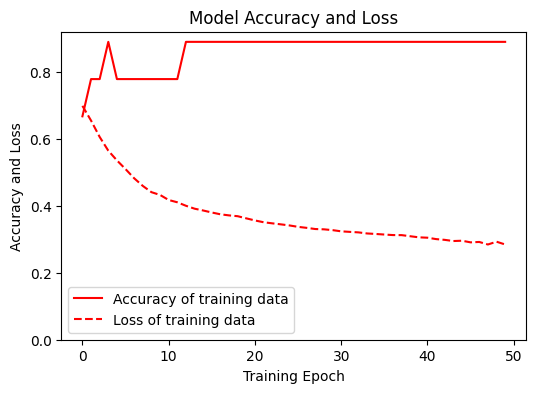

1/1 [==============================] - 0s 473ms/step
              precision    recall  f1-score   support

         0.0       0.44      1.00      0.62         4
         1.0       0.00      0.00      0.00         5

    accuracy                           0.44         9
   macro avg       0.22      0.50      0.31         9
weighted avg       0.20      0.44      0.27         9



In [214]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

y_pred_train = model.predict(x_train)
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

## Test

### Normalize test data

In [216]:
df_test['X1'] = (df_test['X1']-df_test['X1'].min())/(df_test['X1'].max()-df_test['X1'].min())
df_test['Y1'] = (df_test['Y1']-df_test['Y1'].min())/(df_test['Y1'].max()-df_test['Y1'].min())
df_test['Z1'] = (df_test['Z1']-df_test['Z1'].min())/(df_test['Z1'].max()-df_test['Z1'].min())
df_test['X2'] = (df_test['X2']-df_test['X2'].min())/(df_test['X2'].max()-df_test['X2'].min())
df_test['Y2'] = (df_test['Y2']-df_test['Y2'].min())/(df_test['Y2'].max()-df_test['Y2'].min())
df_test['Z2'] = (df_test['Z2']-df_test['Z2'].min())/(df_test['Z2'].max()-df_test['Z2'].min())
df_test['X3'] = (df_test['X3']-df_test['X3'].min())/(df_test['X3'].max()-df_test['X3'].min())
df_test['Y3'] = (df_test['Y3']-df_test['Y3'].min())/(df_test['Y3'].max()-df_test['Y3'].min())
df_test['Z3'] = (df_test['Z3']-df_test['Z3'].min())/(df_test['Z3'].max()-df_test['Z3'].min())
df_test

,user-id,activity,timestamp,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3,activityEncode
0,33,Jogging,1.676523,0.633651,0.245509,0.409864,0.725339,0.666639,0.495287,0.725339,0.666639,0.495287,0
1,33,Jogging,2.676523,0.567944,0.230657,0.405948,0.735166,0.640756,0.488313,0.735166,0.640756,0.488313,0
2,33,Jogging,3.676523,0.534111,0.244610,0.420652,0.740375,0.615254,0.487925,0.740375,0.615254,0.487925,0
3,33,Jogging,4.676523,0.531880,0.262969,0.427319,0.754450,0.585965,0.492474,0.754450,0.585965,0.492474,0
4,33,Jogging,5.676523,0.531059,0.269201,0.440353,0.749385,0.564908,0.498939,0.749385,0.564908,0.498939,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,34,Jogging,805.676523,0.653639,0.224662,0.473069,0.620235,0.674230,0.516824,0.620235,0.674230,0.516824,0
805,34,Jogging,806.676523,0.670469,0.219055,0.462996,0.613585,0.676086,0.513147,0.613585,0.676086,0.513147,0
806,34,Jogging,807.676523,0.682613,0.212919,0.459658,0.610040,0.670524,0.509670,0.610040,0.670524,0.509670,0
807,34,Jogging,808.676523,0.685388,0.201808,0.459156,0.604806,0.656344,0.505274,0.604806,0.656344,0.505274,0


### Segmentation & Reshaping

In [218]:
x_test, y_test = segments2(df_test,
                         TIME_PERIOD,
                         STEP_DISTANCE,
                         LABEL)

x_test = x_test.reshape(x_test.shape[0], input_shape)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test = to_categorical(y_test, num_classes)

### Evaluate

In [219]:
score = model.evaluate(x_test, y_test)
print("Accuracy:", score[1])
print("Loss:", score[0])

1/1 [==============================] - 1s 551ms/step - loss: 0.5056 - accuracy: 1.0000
Accuracy: 1.0
Loss: 0.5056101679801941


1/1 [==============================] - 0s 42ms/step


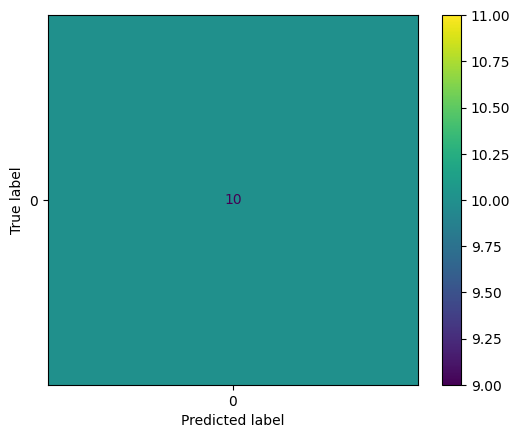

In [220]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm)
cm_disp.plot()
plt.show()

In [ ]:
print(classification_report(y_test_pred, predictions))